# Goal


We're going to train 25 models, every one with different weights initialization. Each weights init will have Gaussian random numbers, with standard deviations between 0.0001 and 10 in 25 logarithmic steps.

## Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
display.set_matplotlib_formats('svg')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

/tmp/ipython-input-4083439555.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [3]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

labels = data[:,0]
data = data[:,1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)

# normalization
data_norm = data / torch.max(data)

# Split

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def CreateNet():

    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, 128)
            self.fc1 = nn.Linear(128, 64)
            self.fc2 = nn.Linear(64, 64)
            self.output = nn.Linear(64, 10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)  # bez softmaxa tutaj

    net = Net()

    # CrossEntropyLoss sam robi log_softmax + NLLLoss w jednym
    loss_fn = nn.CrossEntropyLoss()

    # SGD zamiast Adama — różnice w std będą faktycznie widoczne
    optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9)

    return net, loss_fn, optimizer

# Train

In [ ]:
def ModelTrain(net, loss_fn, optimizer, epochs, verbose):

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses, net

# Weights Init

In [ ]:
def weights_layers_plot(net, title):
  layers_count = sum(1 for m in net.modules() if isinstance(m, (nn.Linear, nn.Conv2d)))

  fig, axs = plt.subplots(1, layers_count, figsize = (3 * layers_count, 5))

  l_idx = 0
  for layer in net.named_parameters():
    if 'weight' in layer[0]:
      axs[l_idx].hist(layer[1].detach())
      axs[l_idx].set_title(layer[0].split('.')[0] + ' layer')
      l_idx += 1

  if title:
    plt.suptitle(title)
  plt.tight_layout()
  plt.show()

In [ ]:
def weights_gaussian_init(net, std):
  default_weights = []
  gaussian_weights = []

  for layer in net.named_parameters():
    if 'weight' in layer[0]:
      default_weights.append(layer[1].data)
      layer[1].data = torch.randn_like(layer[1].data) * std
      gaussian_weights.append(layer[1].data)

  return default_weights, gaussian_weights

## Default Init

In [ ]:
net, loss_fn, optimizer = CreateNet()

In [ ]:
weights_layers_plot(net, title = 'Default Weights Initialization')

## Gaussian Init

Now, we're going to apply gaussina weights initialization and see how weights look like.

In [ ]:
std = 2
_, _ = weights_gaussian_init(net, std = std)
weights_layers_plot(net, title = f'Gaussian Weights Initialization with std = {std}')

# Experiment Setup

In [ ]:
exper_stds = torch.logspace(-4, 1, 25)
exper_stds

tensor([1.0000e-04, 1.6156e-04, 2.6102e-04, 4.2170e-04, 6.8129e-04, 1.1007e-03,
        1.7783e-03, 2.8730e-03, 4.6416e-03, 7.4989e-03, 1.2115e-02, 1.9573e-02,
        3.1623e-02, 5.1090e-02, 8.2540e-02, 1.3335e-01, 2.1544e-01, 3.4807e-01,
        5.6234e-01, 9.0852e-01, 1.4678e+00, 2.3714e+00, 3.8312e+00, 6.1897e+00,
        1.0000e+01])

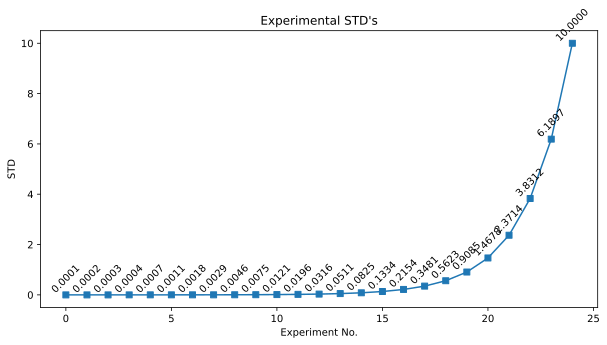

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(exper_stds, '-s')
plt.title('Experimental STD\'s')
plt.ylabel('STD')
plt.xlabel('Experiment No.')
for i, v in enumerate(exper_stds):
  plt.text(i, v, f'{v:.4f}', ha = 'center', va = 'bottom', rotation = 45)
plt.show()

# Execute

In [ ]:
EPOCHS = 50

exp_train_accs = torch.zeros(len(exper_stds), EPOCHS)
exp_test_accs = torch.zeros(len(exper_stds), EPOCHS)
nets = []
post_training_weights_storage = []
gaussian_weights_storage = []

for i, std in enumerate(exper_stds):
  print(f'\n===================== PROCESSING EXPERIMENT STD = {std:.4f} =====================\n')

  # Call new net
  net, loss_fn, optimizer = CreateNet()

  # Change weights into Gaussian dist
  default_weights, gaussian_weights = weights_gaussian_init(net, std = std.item())

  # Train
  train_accs, test_accs, losses, net = ModelTrain(net, loss_fn, optimizer, epochs = EPOCHS, verbose = True)

  # Post Training Weights
  post_training_weights = []
  for layer in net.named_parameters():
    if 'weight' in layer[0]:
      post_training_weights.append(layer[1].data)

  # Save
  exp_train_accs[i, :] = torch.tensor(train_accs)
  exp_test_accs[i, :] = torch.tensor(test_accs)
  # nets.append(net)
  post_training_weights_storage.append(post_training_weights)
  gaussian_weights_storage.append(gaussian_weights)


===================== PROCESSING EXPERIMENT STD = 0.0001 =====================

Epoch: 0 | Train Acc: 11.09 | Test Acc: 10.32 | Loss: 2.30
Epoch: 10 | Train Acc: 53.80 | Test Acc: 74.78 | Loss: 1.18
Epoch: 20 | Train Acc: 97.37 | Test Acc: 96.07 | Loss: 0.09
Epoch: 30 | Train Acc: 98.97 | Test Acc: 95.42 | Loss: 0.03
Epoch: 40 | Train Acc: 99.13 | Test Acc: 96.25 | Loss: 0.03

===================== PROCESSING EXPERIMENT STD = 0.0002 =====================

Epoch: 0 | Train Acc: 10.91 | Test Acc: 10.32 | Loss: 2.30
Epoch: 10 | Train Acc: 10.85 | Test Acc: 10.18 | Loss: 2.30
Epoch: 20 | Train Acc: 11.04 | Test Acc: 10.18 | Loss: 2.30
Epoch: 30 | Train Acc: 11.48 | Test Acc: 10.02 | Loss: 2.30
Epoch: 40 | Train Acc: 10.89 | Test Acc: 10.18 | Loss: 2.30

===================== PROCESSING EXPERIMENT STD = 0.0003 =====================

Epoch: 0 | Train Acc: 10.52 | Test Acc: 10.18 | Loss: 2.30
Epoch: 10 | Train Acc: 42.72 | Test Acc: 60.72 | Loss: 1.32
Epoch: 20 | Train Acc: 97.72 | Test Acc:

We can observe vanishing and exploding gradients.

Higher standard deviations cause weights being bigger. Due to that, our gradient is likely to explode, then we can see Loss: nan. On the contrary when standard deviation is low, or extremly low our weights are small as well. That causes vanishing gradient. We can see losses that are stuck at 2.30, that shows us loss doesn't decrease, and that's due to vanishing gradient.

# Plots

## Gaussian Init vs Post Training Distributions

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: R

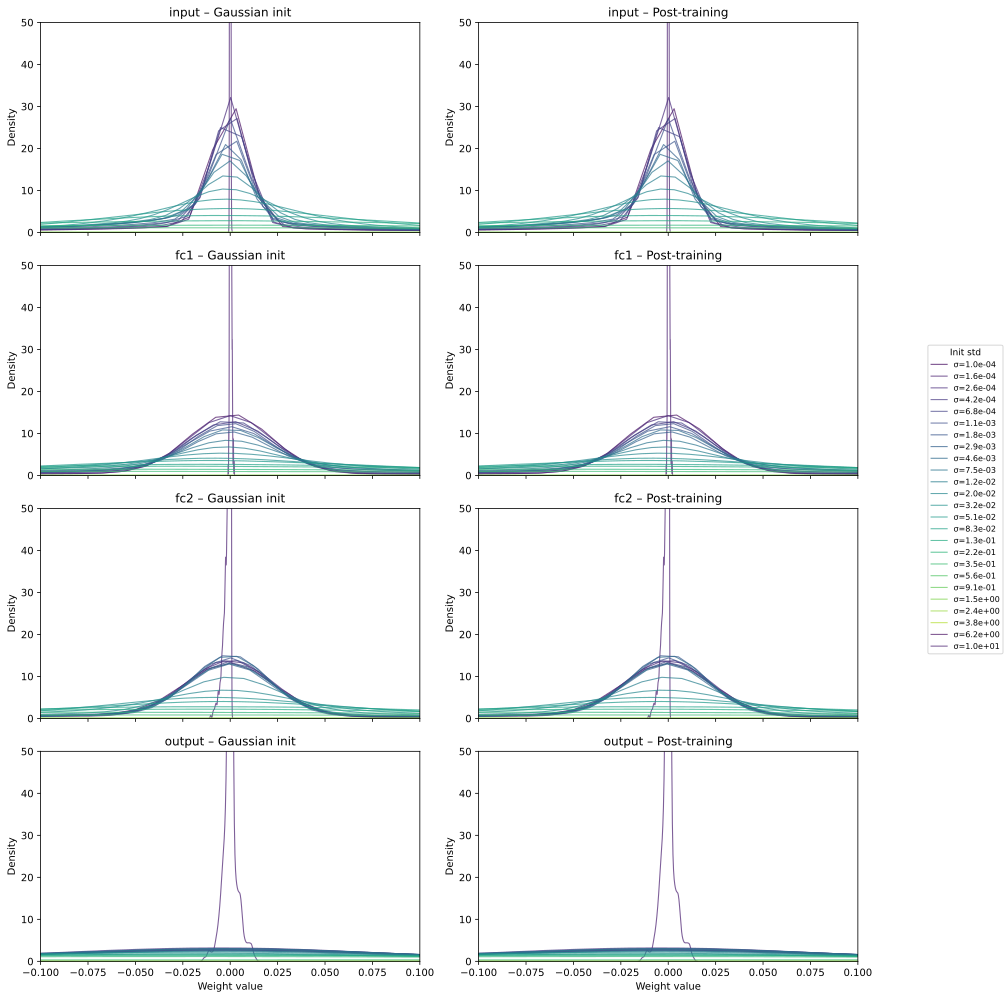

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

layers_count = sum(1 for m in net.modules() if isinstance(m, (nn.Linear, nn.Conv2d)))

names = []
for name, _ in net.named_parameters():
    if 'weight' in name:
        names.append(name.split('.')[0])

palette = sns.color_palette("viridis", n_colors=len(exper_stds))

fig, axes = plt.subplots(layers_count, 2, figsize=(14, 3.5 * layers_count), sharex=True)

for layer in range(layers_count):
    for col, storage, title_suffix in zip(
        [0, 1],
        [gaussian_weights_storage, post_training_weights_storage],
        ["Gaussian init", "Post-training"]
    ):
        ax = axes[layer, col] if layers_count > 1 else axes[col]

        for exp, std in enumerate(exper_stds):
            data = np.ravel(storage[exp][layer].detach().cpu().numpy())
            var = np.var(data)
            if var == 0 or np.isnan(var):
                continue  # pomiń płaskie dane (zero variance)

            sns.kdeplot(
                data=data,
                ax=ax,
                color=palette[exp],
                lw=1.1,
                alpha=0.7,
                warn_singular=False
            )

        ax.set_title(f"{names[layer]} – {title_suffix}")
        ax.set_ylabel("Density")
        ax.set_xlim(-0.1, 0.1)  # przybliżenie do sensownego zakresu
        ax.set_ylim(0, 50)    # automatyczne dopasowanie wysokości
        if layer == layers_count - 1:
            ax.set_xlabel("Weight value")

# Legenda globalna
legend_labels = [f"σ={float(std):.1e}" for std in exper_stds]
fig.legend(legend_labels, title="Init std", loc='center right', fontsize=8, title_fontsize=9)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

## Train and Test Accs

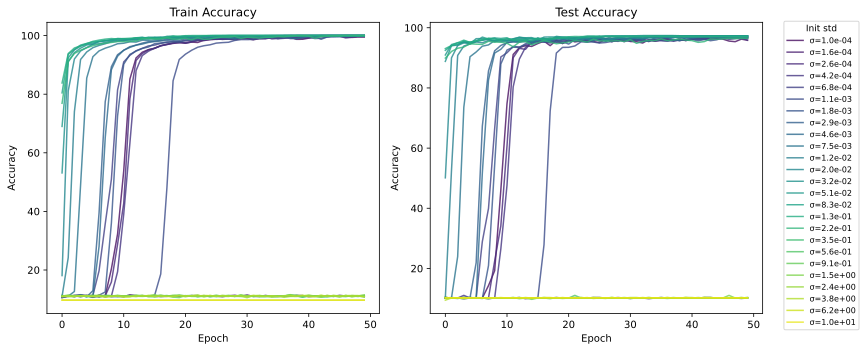

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("viridis", n_colors=len(exper_stds))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for exp, std in enumerate(exper_stds):
    ax[0].plot(exp_train_accs[exp], color=palette[exp], lw=1.5, alpha=0.8)
    ax[1].plot(exp_test_accs[exp],  color=palette[exp], lw=1.5, alpha=0.8)

ax[0].set_title('Train Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Test Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

legend_labels = [f"σ={float(std):.1e}" for std in exper_stds]
fig.legend(legend_labels, title="Init std", loc='center right', fontsize=8, title_fontsize=9)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


## Final Train and Test Accs

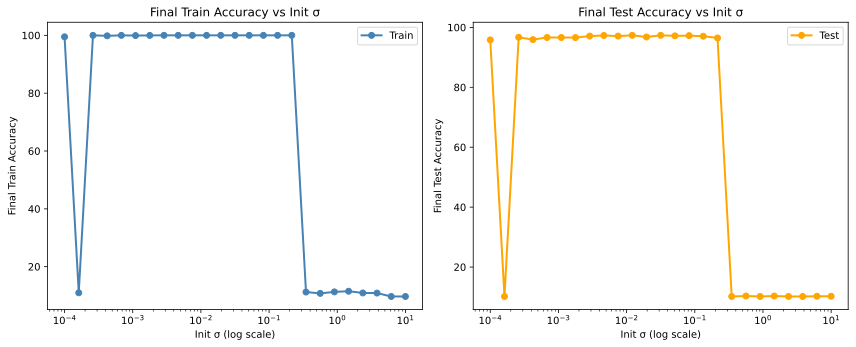

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

palette = sns.color_palette("viridis", n_colors=len(exper_stds))

final_train = exp_train_accs[:, -1].cpu().numpy()
final_test = exp_test_accs[:, -1].cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- TRAIN ---
ax[0].plot(exper_stds, final_train, marker='o', lw=2, color='steelblue', label='Train')
ax[0].set_xscale('log')
ax[0].set_xlabel("Init σ (log scale)")
ax[0].set_ylabel("Final Train Accuracy")
ax[0].set_title("Final Train Accuracy vs Init σ")
ax[0].legend()

# --- TEST ---
ax[1].plot(exper_stds, final_test, marker='o', lw=2, color='orange', label='Test')
ax[1].set_xscale('log')
ax[1].set_xlabel("Init σ (log scale)")
ax[1].set_ylabel("Final Test Accuracy")
ax[1].set_title("Final Test Accuracy vs Init σ")
ax[1].legend()

plt.tight_layout()
plt.show()


As we can see the problem we have is mostly with extreem standard deviations either too small or too high.